In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn.model_selection import GridSearchCV
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
import os
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
print(os.listdir("../input"))
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


**data loaded**

Upload train,test,sub

In [2]:
df=pd.read_csv('../input/train.csv')
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
x_testFINAL=pd.read_csv('../input/test.csv')
sub=pd.read_csv('../input/sample_submission.csv')
x_testFINAL.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [4]:
print(df.groupby('target').describe())
print("shape of dataset::" +str(df.shape))

           var_0                        ...     var_99                 
           count       mean       std   ...        50%      75%     max
target                                  ...                            
0       179902.0  10.626681  3.008564   ...   -0.80675  0.48530  5.0764
1        20098.0  11.156418  3.270293   ...   -0.39600  0.93475  4.9939

[2 rows x 1600 columns]
shape of dataset::(200000, 202)


Splitted into train and test

In [5]:
df=shuffle(df)
df_test=df.iloc[:12000,:]
df_train=df.iloc[12000:,:]

In [6]:
df_train.shape

(188000, 202)

**Feature Engineering**

REMOVE OUTLIER

** Discover outliers with visualization tools**

Box Plot

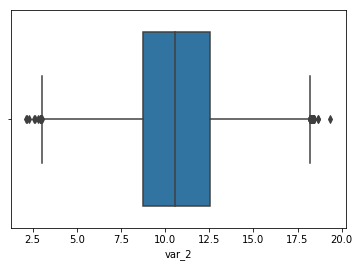

In [7]:
import seaborn as sns
x_train=df_train.iloc[:,2:]
y_train=df_train['target']
sns.boxplot(x=x_train['var_2'])

In [8]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df_train.iloc[:,1:]))
threshold = 3
df_train_rm = df_train[(z < threshold).all(axis=1)]
print('df_train_rm shape :'+str(df_train_rm.shape))
print('df_train shape :'+str(df_train.shape))

df_train_rm shape :(177637, 202)
df_train shape :(188000, 202)


In [9]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

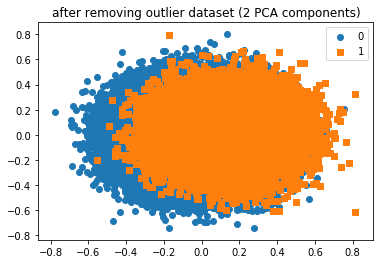

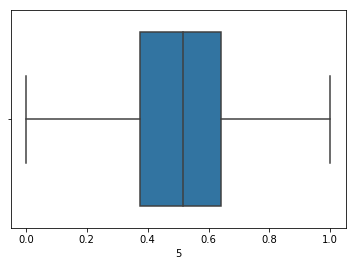

In [10]:
x_train1=df_train_rm.iloc[:,2:]
y_train1=df_train_rm.iloc[:,1]
min_max_scaler =MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x_train1)
x_train1 = pd.DataFrame(np_scaled)

pca = PCA(n_components=2)
x_plot1 = pca.fit_transform(x_train1)
plot_2d_space(x_plot1,y_train1, 'after removing outlier dataset (2 PCA components)')
sns.boxplot(x=x_train1.iloc[:,5])

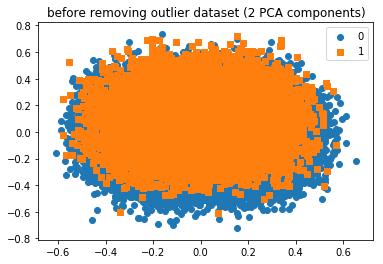

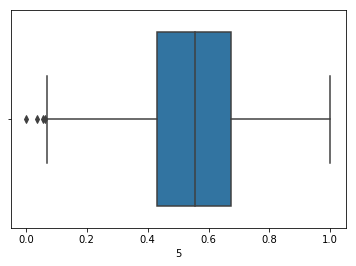

In [11]:
x_train=df_train.iloc[:,2:]
y_train=df_train['target']
min_max_scaler =MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(x_train)
x_train = pd.DataFrame(np_scaled)

pca = PCA(n_components=2)
x_plot= pca.fit_transform(x_train)
plot_2d_space(x_plot,y_train, 'before removing outlier dataset (2 PCA components)')
sns.boxplot(x=x_train.iloc[:,5])

**Imbalanced by Over Sampling**

Random over-sampling:
0    159940
1     79970
Name: target, dtype: int64


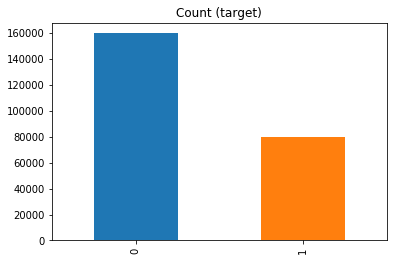

In [14]:
# Class count
count_class_0, count_class_1 = df_train_rm.target.value_counts()

# Divide by class
df_train_rm_class_0 = df_train_rm[df_train_rm['target'] == 0]
df_train_rm_class_1 = df_train_rm[df_train_rm['target'] == 1]
frac=.5
df_train_rm_class_1_over = df_train_rm_class_1.sample(int(count_class_0*frac), replace=True)
df_test_over = pd.concat([df_train_rm_class_0, df_train_rm_class_1_over], axis=0)
df_test_over=shuffle(df_test_over)
print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)'); 

In [15]:
df_ov=df_test_over.iloc[:,2:]
min_max_scaler =MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_ov)
df_normov = pd.DataFrame(np_scaled)
df_normov.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.570989,0.637635,0.274070,0.417521,0.480289,0.627434,0.362053,0.517430,0.305482,0.417529,0.234632,0.402513,0.555082,0.525358,0.284407,0.632062,0.350650,0.415119,0.173724,0.314006,0.703820,0.268574,0.417456,0.502236,0.408632,0.549048,0.628693,0.481096,0.360637,0.268166,0.686032,0.578616,0.402970,0.211881,0.618792,0.678657,0.372801,0.649434,0.369822,0.085702,...,0.524541,0.802982,0.506911,0.444073,0.514449,0.413474,0.706611,0.384776,0.344437,0.538448,0.515826,0.395654,0.539145,0.591009,0.610716,0.602135,0.563584,0.376349,0.798813,0.238341,0.274250,0.383689,0.562416,0.505073,0.719019,0.581759,0.542445,0.401004,0.562230,0.436724,0.527615,0.628134,0.801261,0.479713,0.201321,0.663400,0.689545,0.344217,0.697264,0.566818
1,0.410190,0.173152,0.579500,0.702111,0.623079,0.793130,0.382424,0.629774,0.664119,0.595925,0.508553,0.669329,0.527858,0.657311,0.710113,0.468479,0.450719,0.399426,0.633146,0.856582,0.681947,0.481488,0.507214,0.445342,0.676719,0.695083,0.543398,0.692739,0.396998,0.467267,0.579909,0.610575,0.406640,0.585829,0.675366,0.512082,0.347682,0.746088,0.472113,0.346423,...,0.194337,0.262999,0.735488,0.282570,0.608659,0.421290,0.712463,0.800191,0.337033,0.352278,0.339829,0.271999,0.443626,0.183417,0.559319,0.389888,0.290943,0.367941,0.457627,0.582423,0.417737,0.464387,0.631878,0.562661,0.223537,0.602343,0.397432,0.796505,0.553188,0.494905,0.507525,0.136073,0.542646,0.448138,0.234639,0.535513,0.539631,0.311364,0.295409,0.197107
2,0.478280,0.468131,0.524909,0.370240,0.395686,0.904459,0.721248,0.429004,0.326698,0.603766,0.336192,0.743207,0.474955,0.502930,0.270853,0.672712,0.322629,0.611148,0.489530,0.442286,0.375078,0.665314,0.355651,0.358708,0.713459,0.722644,0.675101,0.563465,0.333792,0.566344,0.770025,0.193431,0.461855,0.289422,0.636529,0.440288,0.310646,0.682707,0.538483,0.425140,...,0.426922,0.382755,0.752140,0.225748,0.771389,0.312552,0.320821,0.769295,0.637501,0.596006,0.318633,0.311527,0.607846,0.615399,0.710167,0.162567,0.679446,0.275463,0.630174,0.124400,0.807560,0.540735,0.608110,0.692241,0.648806,0.641929,0.435786,0.518543,0.700575,0.408292,0.383728,0.489973,0.506289,0.848716,0.592352,0.242072,0.457880,0.285573,0.593163,0.369830
3,0.360381,0.414228,0.735582,0.548180,0.261618,0.746005,0.416931,0.696185,0.632692,0.737483,0.676787,0.715545,0.683938,0.563042,0.291576,0.840388,0.571222,0.391156,0.190460,0.498574,0.716624,0.308639,0.882089,0.359028,0.513951,0.611526,0.370974,0.201748,0.507001,0.337162,0.525206,0.442911,0.841994,0.481608,0.503331,0.359458,0.216881,0.484273,0.687417,0.488009,...,0.490161,0.715136,0.248870,0.334829,0.714025,0.496821,0.460589,0.266414,0.928875,0.265827,0.620112,0.502904,0.376793,0.341220,0.300595,0.548484,0.119343,0.586995,0.454394,0.985018,0.529383,0.350061,0.201197,0.517069,0.608332,0.515005,0.417402,0.502153,0.492592,0.515131,0.541413,0.477237,0.667994,0.513334,0.276354,0.451030,0.603956,0.771714,0.667787,0.459855
4,0.315560,0.647608,0.584373,0.601836,0.575060,0.692272,0.183112,0.357060,0.418560,0.655590,0.437339,0.314948,0.693285,0.367277,0.591836,0.353570,0.772483,0.311724,0.250861,0.503634,0.698598,0.425453,0.510701,0.391004,0.669472,0.540348,0.911684,0.538267,0.538980,0.504732,0.411542,0.520427,0.257441,0.382940,0.504535,0.432333,0.360107,0.606250,0.257663,0.417770,...,0.479071,0.615854,0.571242,0.268438,0.605550,0.503419,0.076719,0.502334,0.357442,0.471470,0.376596,0.193236,0.472014,0.729216,0.172476,0.691643,0.397940,0.755424,0.541354,0.394509,0.680971,0.432206,0.502387,0.414664,0.560902,0.620305,0.380893,0.284080,0.578921,0.413541,0.429581,0.207413,0.595337,0.631226,0.429831,0.326719,0.513575,0.390168,0.552656,0.605502


In [16]:
X_test=df_test.iloc[:,1:]
y_test=df_test['target']

In [17]:
X=df_normov
Y=df_test_over['target']
df_testnorm=df_test.iloc[:,2:]
min_max_scaler =MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_testnorm)
df_testnorm = pd.DataFrame(np_scaled)

X_test=df_testnorm
y_test=df_test['target']

In [18]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [19]:
model = XGBClassifier(n_estimators=300,max_dapth=10)
model.fit(X, Y)
y_pred_xgb = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.06%


In [ ]:
#y_predoverrfc = clf.predict(X)
#accuracy = accuracy_score(Y, y_predoverrfc)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#clf_ada= AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=100)
#clf_ada.fit(X,Y)
#y_predoverada = clf_ada.predict(X_test)
#accuracy = accuracy_score(y_test, y_predoverada)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [13]:
bag=BaggingClassifier(DecisionTreeClassifier(),max_samples=.3,max_features=1.0,n_estimators=300)
bag.fit(X,Y)
y_predoverbag = bag.predict(X_test)
accuracy = accuracy_score(y_test, y_predoverbag)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

NameError: name 'X' is not defined

In [ ]:
svm=SVC()

Confusion matrix:
 [[9683 1118]
 [ 435  764]]


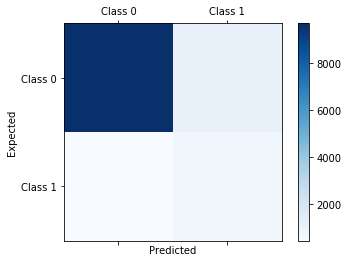

In [20]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_xgb)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [21]:
mysat0=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
print('acc_0::'+str(mysat0))
mysat1=conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
print('acc_1::'+str(mysat1))

acc_0::0.8964910656420702
acc_1::0.6371976647206005


In [22]:
df_ov=x_testFINAL.iloc[:,1:]
min_max_scaler =MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_ov)
x_test_final = pd.DataFrame(np_scaled)

In [24]:
y_predFINAL = pd.DataFrame(model.predict(x_test_final))
y_predexp=y_predFINAL
sub['target']=y_predexp.iloc[:,:]
sub.to_csv('submission.csv', index=False)